In [2]:
import numpy as np
import random
from tqdm._tqdm_notebook import tqdm # for progress bars in notebook



/var/folders/kc/1cm01sgd3jdg2k6jhbbdxl740000gn/T/ipykernel_38598/606428152.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm # for progress bars in notebook


In [3]:
import os
import cv2
import pickle




In [4]:
def detect_faces(image):

    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    return faces

In [5]:
import os
import cv2
import numpy as np
from tqdm import tqdm

# Assuming detect_faces and apply_esrgan functions are already defined

datasets = ['train_ds', 'val_ds', 'test_ds']
extract_dir = 'dataset'  # Adjust this to your actual extract directory
output_dir = 'processed_images_128'  # Directory to save processed images

# Initialize lists for storing preprocessed images
train_preprocessed = []
val_preprocessed = []
test_preprocessed = []

train_labels = []
val_labels = []
test_labels = []

def load_images_and_labels(dataset):
    images = []
    labels = []
    dataset_path = os.path.join(extract_dir, dataset)
    people_folders = [f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))]

    progress_bar = tqdm(total=len(people_folders), desc=f'Processing {dataset}', unit='folder')

    for person_folder in people_folders:
        person_path = os.path.join(dataset_path, person_folder)
        image_files = [os.path.join(person_path, f) for f in os.listdir(person_path) if f.endswith('.jpg') or f.endswith('.png')]
        label = person_folder
        for image_path in image_files:
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            faces = detect_faces(image)

            for (x, y, w, h) in faces:
                # Extract the face ROI
                face_roi = image[y:y+h, x:x+w]

                # Convert to grayscale
                gray_face = cv2.cvtColor(face_roi, cv2.COLOR_BGR2GRAY)

                # Resize the face to the target size
                target_size = (128, 128)
                resized_face = cv2.resize(gray_face, target_size)

                # Save processed image
                filename = os.path.basename(image_path)
                output_path = os.path.join(output_dir, dataset, person_folder, filename)
                os.makedirs(os.path.dirname(output_path), exist_ok=True)
                cv2.imwrite(output_path, resized_face)

                images.append(resized_face)
                labels.append(label)
        
        progress_bar.update(1)

    progress_bar.close()
    return images, labels

# Call the function to load and process images
train_preprocessed, train_labels = load_images_and_labels('train_ds')
val_preprocessed, val_labels = load_images_and_labels('val_ds')
test_preprocessed, test_labels = load_images_and_labels('test_ds')

print("Image loading completed!")


Processing test_ds: 100%|███████████████████| 35/35 [00:23<00:00,  1.51folder/s]

Image loading completed!


# Extract EigenVectors

In [6]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        if os.path.isdir(file_path) or not file_path.endswith(('.png', '.jpg', '.jpeg')):
            continue
        img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img.flatten())
    return images


In [7]:
def compute_pca(images):
    # Compute mean image
    mean_image = np.mean(images, axis=0)
    
    # Initialize covariance matrix
    cov_matrix = np.zeros((mean_image.shape[0], mean_image.shape[0]))
    
    # Compute covariance matrix
    for image in tqdm(images, desc='Computing Covariance'):
        diff = image - mean_image
        cov_matrix += np.outer(diff, diff)
    cov_matrix /= (len(images) - 1)  # Normalize by N-1
    
    # Compute eigenvectors
    eig_vals, eig_vecs = np.linalg.eigh(cov_matrix)
    sorted_indices = np.argsort(-eig_vals)
    eig_vecs = eig_vecs[:, sorted_indices]
    
    # Return top k eigenvectors
    return eig_vecs

In [8]:
def project_2dpca(images, eig_vecs):
    return np.dot(images, eig_vecs)


In [9]:
def generate_pairs(dataset_dir):
    pairs = []
    labels = []
    persons = os.listdir(dataset_dir)
    persons = [person for person in persons if os.path.isdir(os.path.join(dataset_dir, person))]
    
    for person in tqdm(persons):
        person_dir = os.path.join(dataset_dir, person)
        images = load_images_from_folder(person_dir)
        pairs += images
        #other_persons = [p for p in persons if p != person]
        
        # if len(images) < 2:
        #     continue  # Skip if there are not enough images to form pairs
        
        # Generate all positive pairs
        #for i in range(len(images)):
            # j = random.choice([j for j in list(range(len(images))) if j != i])
            # pairs.append((images[i], images[j]))
            # labels.append(1)
            # while True:
            #     other_person = random.choice(other_persons)
            #     other_person_dir = os.path.join(dataset_dir, other_person)
            #     other_images = load_images_from_folder(other_person_dir)
            #     if len(other_images) > 0:
            #         break  # Ensure we get a non-empty list of images
                
            # other_image = random.choice(other_images)
            # pairs.append((images[i], other_image))
            # labels.append(0)
            
    
    # Shuffle the pairs and labels together
    # combined = list(zip(pairs, labels))
    # random.shuffle(combined)
    # pairs, labels = zip(*combined)
    
    return np.array(pairs)#, np.array(labels)


In [10]:
train_dir='processed_images_128/train_ds'
# test_dir='/Users/apoorvagayatrik/PerspectAIProj/processed_images_128/test_ds'
# val_dir='/Users/apoorvagayatrik/PerspectAIProj/processed_images_128/val_ds'

In [11]:
train_pairs = generate_pairs(train_dir)
# val_pairs, val_labels = generate_pairs(val_dir)
# test_pairs, test_labels = generate_pairs(test_dir)
#print(f"Generated {len(train_pairs)} pairs with {np.sum(train_labels)} positives and {len(train_labels) - np.sum(train_labels)} negatives")
# print(f"Generated {len(val_pairs)} pairs with {np.sum(val_labels)} positives and {len(val_labels) - np.sum(val_labels)} negatives")
# print(f"Generated {len(test_pairs)} pairs with {np.sum(test_labels)} positives and {len(test_labels) - np.sum(test_labels)} negatives")


100%|████████████████████████████████████████| 140/140 [00:00<00:00, 453.22it/s]


In [12]:
k=[30,40,50,60]

In [13]:
train_pairs.shape

(1092, 16384)

In [14]:
import pickle

In [15]:
eig_vecs = compute_pca(train_pairs)
#with open(f'eig_vecsk_128sept10.pkl', 'wb') as file:
    #pickle.dump(eig_vecs, file)




Computing Covariance: 100%|█████████████████| 1092/1092 [10:42<00:00,  1.70it/s]


In [17]:
with open(f'eig_vecsk_128sept10.pkl', 'wb') as file:
    pickle.dump(eig_vecs, file)

In [18]:
train_pairs[0].shape

(16384,)

In [20]:
def generate_pairs2(dataset_dir, num_pairs=1000):
    pairs = []
    labels = []
    persons = os.listdir(dataset_dir)
    persons = [person for person in persons if os.path.isdir(os.path.join(dataset_dir, person))]
    
    # Generate positive pairs
    for person in tqdm(persons, desc='Generating positive pairs'):
        person_dir = os.path.join(dataset_dir, person)
        images = load_images_from_folder(person_dir)
        if len(images) < 2:
            continue  # Skip if there aren't enough images for a pair
        
        for _ in range(num_pairs // len(persons)):  # Create a balanced number of pairs
            img1, img2 = random.sample(images, 2)  # Two different images of the same person
            pairs.append((img1, img2))
            labels.append(1)  # Label as a positive pair
    
    # Generate negative pairs
    for _ in tqdm(range(num_pairs), desc='Generating negative pairs'):
        person1, person2 = random.sample(persons, 2)  # Two different persons
        person1_dir = os.path.join(dataset_dir, person1)
        person2_dir = os.path.join(dataset_dir, person2)
        
        img1 = random.choice(load_images_from_folder(person1_dir))
        img2 = random.choice(load_images_from_folder(person2_dir))
        
        pairs.append((img1, img2))
        labels.append(0)  # Label as a negative pair
    
    # Shuffle the pairs and labels together
    combined = list(zip(pairs, labels))
    random.shuffle(combined)
    pairs, labels = zip(*combined)
    
    return np.array(pairs), np.array(labels)

# Example usage:
train_dir = 'processed_images_128/train_ds'
val_dir = 'processed_images_128/val_ds'
test_dir = 'processed_images_128/test_ds'
train_pairs, train_labels = generate_pairs2(val_dir, num_pairs=1000)

val_pairs, val_labels = generate_pairs2(val_dir, num_pairs=1000)
test_pairs, test_labels = generate_pairs2(test_dir, num_pairs=1000)

print(f"Generated {len(val_pairs)} training pairs with {np.sum(val_labels)} positives and {len(val_labels) - np.sum(val_labels)} negatives.")
print(f"Generated {len(test_pairs)} training pairs with {np.sum(test_labels)} positives and {len(test_labels) - np.sum(test_labels)} negatives.")

Generating negative pairs: 100%|███████████| 1000/1000 [00:03<00:00, 264.51it/s]

Generated 1980 training pairs with 980 positives and 1000 negatives.
Generated 1990 training pairs with 990 positives and 1000 negatives.


###### Plot the Eigen Values

In [21]:
import numpy as np
import matplotlib.pyplot as plt



# Plot the eigenvalues
plt.figure(figsize=(100, 100))
plt.plot(range(1, len(eig_vecs) + 1), eig_vecs, marker='o', linestyle='--', color='b')
plt.title('Eigenvalues of Principal Components')
plt.xlabel('Principal Component Index')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

KeyboardInterrupt: 

Shape of eigen_vecs: (16384, 16384)


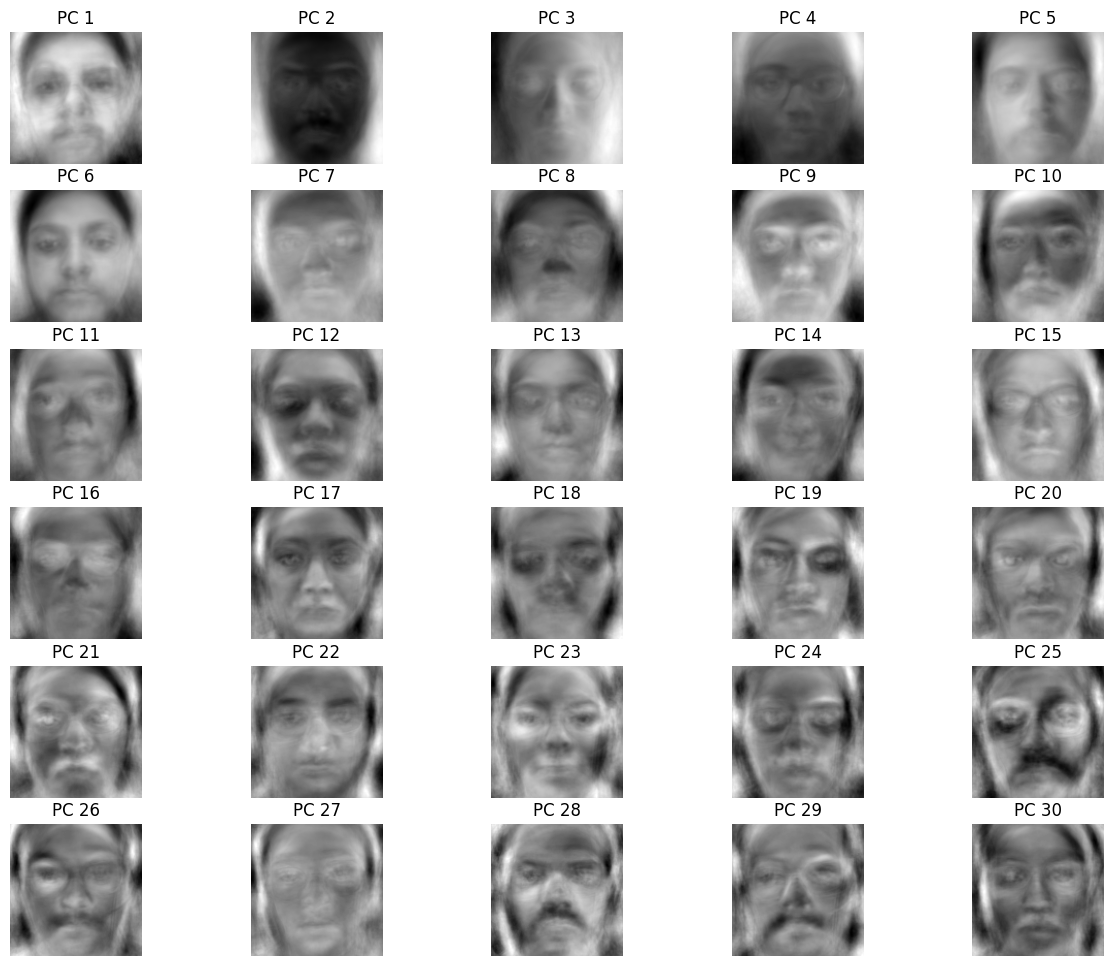

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt


# Check the shape of eigen_vecs
print("Shape of eigen_vecs:", eig_vecs.shape)  # Should print (4096, 30)

# Reshape and visualize the first few eigenvectors
num_components_to_plot = 30  # Limit to the first 5 eigenvectors for visualization
plt.figure(figsize=(15,12))

for i in range(num_components_to_plot):
    eigenvector = eig_vecs[:, i]  # Extract each eigenvector
    eigenvector_image = eigenvector.reshape((128, 128))  # Reshape to 64x64 image
    plt.subplot(6, 5, i + 1)
    plt.imshow(eigenvector_image, cmap='gray')
    plt.title(f'PC {i + 1}')
    plt.axis('off')

plt.show()


# USING KNN CLASSIFIER

In [25]:
train_features = []
for img1, img2 in tqdm(train_pairs, desc='Training pairs'):
    proj_img1 = project_2dpca(img1.flatten(), eig_vecs)
    proj_img2 = project_2dpca(img2.flatten(), eig_vecs)
    train_features.append(np.concatenate([proj_img1, proj_img2]))
train_features = np.array(train_features)
    

Training pairs: 100%|███████████████████████| 1980/1980 [03:32<00:00,  9.32it/s]


In [26]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=12)
knn.fit(train_features, train_labels)


KNeighborsClassifier(n_neighbors=12)

In [28]:
val_features = []
for img1, img2 in tqdm(val_pairs, desc='Validation pairs'):
    proj_img1 = project_2dpca(img1.flatten(), eig_vecs)
    proj_img2 = project_2dpca(img2.flatten(), eig_vecs)
    val_features.append(np.concatenate([proj_img1, proj_img2]))
val_features = np.array(val_features)


Validation pairs: 100%|█████████████████████| 1980/1980 [02:28<00:00, 13.32it/s]


In [32]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

In [33]:
val_pred = knn.predict(val_features)
val_accuracy = accuracy_score(val_labels, val_pred)
val_precision=precision_score(val_labels, val_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Precision: {val_precision:.4f}")

Validation Accuracy: 0.8354
Validation Precision: 0.7873


In [34]:
test_features = []
for img1, img2 in tqdm(test_pairs, desc='Test pairs'):
        proj_img1 = project_2dpca(img1.flatten(), eig_vecs)
        proj_img2 = project_2dpca(img2.flatten(), eig_vecs)
        test_features.append(np.concatenate([proj_img1, proj_img2]))
test_features = np.array(test_features)

Test pairs: 100%|███████████████████████████| 1990/1990 [03:36<00:00,  9.20it/s]


In [35]:
test_pred = knn.predict(test_features)
test_accuracy = accuracy_score(test_labels, test_pred)
test_precision=precision_score(test_labels, test_pred)

print(f"Test Accuracy: {test_accuracy}")
print(f"Validation Precision: {val_precision:.4f}")

Test Accuracy: 0.742713567839196
Validation Precision: 0.7873


# USING RANDOM FOREST CLASSIFIER

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=10000, random_state=77)

rf_classifier.fit(train_features, train_labels)

In [ ]:
# Save the trained model to a file
with open('rf_classifier10000.pkl', 'wb') as f:
    pickle.dump(rf_classifier, f)

In [ ]:
import pickle
with open('rf_classifier10000.pkl', 'rb') as f:
    rf_classifier = pickle.load(f)


In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=100000, random_state=77)

rf_classifier.fit(train_features, train_labels)

In [ ]:
val_features = []
for img1, img2 in tqdm(val_pairs, desc='Validation pairs'):
    proj_img1 = project_2dpca(img1.flatten(), eig_vecs)
    proj_img2 = project_2dpca(img2.flatten(), eig_vecs)
    val_features.append(np.concatenate([proj_img1, proj_img2]))
val_features = np.array(val_features)

In [ ]:
val_pred = rf_classifier.predict(val_features)
val_accuracy = accuracy_score(val_labels, val_pred)
val_precision=precision_score(val_labels, val_pred)

print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Precision: {val_precision:.9f}")

In [ ]:
test_features = []
for img1, img2 in tqdm(test_pairs, desc='Test pairs'):
        proj_img1 = project_2dpca(img1.flatten(), eig_vecs)
        proj_img2 = project_2dpca(img2.flatten(), eig_vecs)
        test_features.append(np.concatenate([proj_img1, proj_img2]))
test_features = np.array(test_features)

In [ ]:
test_pred = rf_classifier.predict(test_features)
test_accuracy = accuracy_score(test_labels, test_pred)
test_precision=precision_score(test_labels, test_pred)

print(f"Test Accuracy: {test_accuracy}")
print(f"Validation Precision: {val_precision:.9f}")

# USING GRADIENT BOOSTING CLASSIFIER

In [ ]:
!pip install xgboost

In [ ]:
import xgboost as xgb

In [ ]:
xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',  # For binary classification
    max_depth=3,                  # Maximum depth of the tree
    learning_rate=0.1,            # Learning rate
    n_estimators=8000,             # Number of trees (boosting rounds)
    subsample=0.8,                # Subsample ratio of the training instances
    colsample_bytree=0.8,         # Subsample ratio of columns when constructing each tree
    random_state=42,
    eval_metric='error',
    grow_policy='lossguide'        
    # Random state for reproducibility
)


In [ ]:
xgb_classifier.fit(train_features, train_labels)


In [ ]:
val_features = []
for img1, img2 in tqdm(val_pairs, desc='Validation pairs'):
    proj_img1 = project_2dpca(img1.flatten(), eig_vecs)
    proj_img2 = project_2dpca(img2.flatten(), eig_vecs)
    val_features.append(np.concatenate([proj_img1, proj_img2]))
val_features = np.array(val_features)

In [ ]:
val_pred = xgb_classifier.predict(val_features)
val_accuracy = accuracy_score(val_labels, val_pred)
val_precision=precision_score(val_labels, val_pred)

print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Precision: {val_precision:.9f}")

In [ ]:
test_features = []
for img1, img2 in tqdm(test_pairs, desc='Test pairs'):
        proj_img1 = project_2dpca(img1.flatten(), eig_vecs)
        proj_img2 = project_2dpca(img2.flatten(), eig_vecs)
        test_features.append(np.concatenate([proj_img1, proj_img2]))
test_features = np.array(test_features)

In [ ]:
test_pred = xgb_classifier.predict(test_features)
test_accuracy = accuracy_score(test_labels, test_pred)
test_precision=precision_score(test_labels, test_pred)

print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision:.9f}")

# USING MLP CLASSIFIER

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(256,128, 64), activation='relu', 
                               solver='adam', random_state=42, max_iter=1000, verbose=True,
                               learning_rate='adaptive',early_stopping=False,alpha=0.1,
                               learning_rate_init=0.001,n_iter_no_change=500,validation_fraction=0.1)



In [ ]:
history = mlp_classifier.fit(train_features, train_labels)


In [ ]:
val_features = []
for img1, img2 in tqdm(val_pairs, desc='Validation pairs'):
    proj_img1 = project_2dpca(img1.flatten(), eig_vecs)
    proj_img2 = project_2dpca(img2.flatten(), eig_vecs)
    val_features.append(np.concatenate([proj_img1, proj_img2]))
val_features = np.array(val_features)

In [ ]:
val_pred = mlp_classifier.predict(val_features)
val_accuracy = accuracy_score(val_labels, val_pred)
val_precision=precision_score(val_labels, val_pred)

print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Precision: {val_precision:.9f}")

In [ ]:
test_features = []
for img1, img2 in tqdm(test_pairs, desc='Test pairs'):
        proj_img1 = project_2dpca(img1.flatten(), eig_vecs)
        proj_img2 = project_2dpca(img2.flatten(), eig_vecs)
        test_features.append(np.concatenate([proj_img1, proj_img2]))
test_features = np.array(test_features)

In [ ]:
test_pred = mlp_classifier.predict(test_features)
test_accuracy = accuracy_score(test_labels, test_pred)
test_precision=precision_score(test_labels, test_pred)

print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision:.9f}")

In [ ]:
import pickle

# Save the trained model to a file
with open('mlp_classifier_64_esrgan_k30.pkl', 'wb') as f:
    pickle.dump(mlp_classifier, f)


In [ ]:
import pickle
with open('mlp_classifier_64_esrgan_k30.pkl', 'rb') as f:
    mlp_classifier = pickle.load(f)


In [42]:
mlp_classifier.summary()

AttributeError: 'MLPClassifier' object has no attribute 'summary'